# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8256\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4501.67,1.00,-131.89,2316.74,2184.85
OMUSDT,526.32,2672.60,0.59,0.00,2146.28,2146.28
BTCUSDT,601.02,863.10,0.19,3.54,262.08,265.62
SOLUSDT,281.20,350.23,0.08,0.00,69.03,69.03
JASMYUSDT,387.46,288.35,0.06,0.00,-99.11,-99.11
ETHUSDT,250.75,186.13,0.04,0.00,-64.62,-64.62
TRXUSDT,76.87,118.09,0.03,-10.72,41.23,30.51
BBUSDT,60.18,21.98,0.00,-39.73,-38.20,-77.93
BNBUSDT,1.14,1.19,0.00,-10.61,0.05,-10.56
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

439

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [28]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-02-07    2277.788822
2025-02-08    2223.713748
2025-02-09    2368.210080
2025-02-10    2352.361114
2025-02-11    2320.041869
Name: Total, Length: 142, dtype: float64

In [39]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-02-07     81.244272
2025-02-08    -54.075075
2025-02-09    144.496332
2025-02-10    -15.848966
2025-02-11    -32.319246
Name: Total, Length: 142, dtype: float64

In [40]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [41]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [42]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [43]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_8256\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [44]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [45]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [46]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

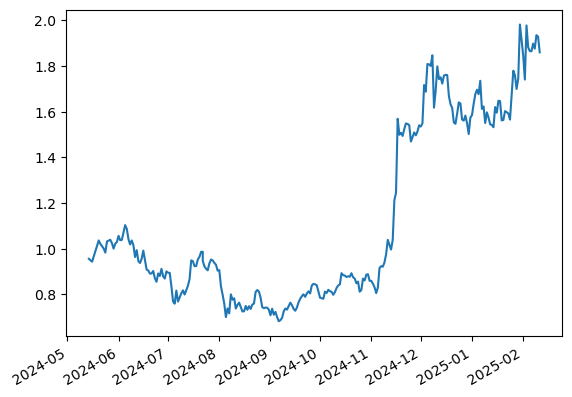

In [47]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

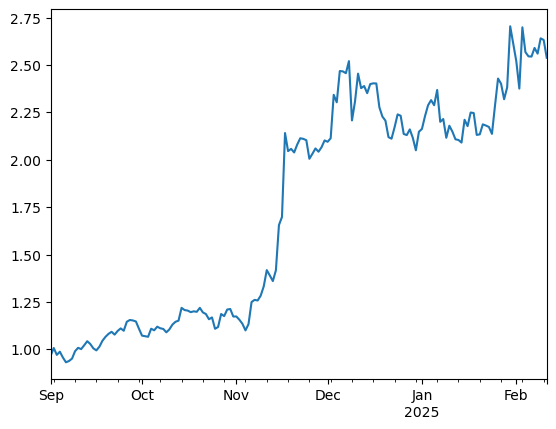

In [48]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [50]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [53]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [54]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [57]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4614
BNBUSDT,0.3095
XRPUSDT,0.1253
SUIUSDT,0.0551
PEPEUSDT,0.0264
DEXEUSDT,0.0118
AAVEUSDT,0.0090
RAYUSDT,0.0012
ADAUSDT,0.0004
BTCUSDT,0.0000


In [58]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']


In [59]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

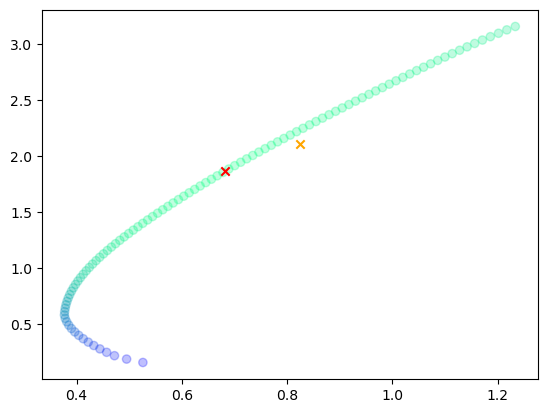

In [60]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [61]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
pd.DataFrame(dico.values(),index=dico.keys(),columns=['Frontier Weights'])

,Frontier Weights
OMUSDT,0.2309
BTCUSDT,0.0000
SOLUSDT,0.0000
JASMYUSDT,0.0000
ETHUSDT,0.0000
TRXUSDT,0.0000
BNBUSDT,0.1582
PEPEUSDT,0.0271
XRPUSDT,0.1258
SUIUSDT,0.0572


In [62]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2672.604561,0.593691,0.425805,0.167886
BTCUSDT,863.101425,0.191729,0.300000,-0.108271
SOLUSDT,350.228575,0.077800,0.000000,0.077800
JASMYUSDT,288.352007,0.064054,0.000000,0.064054
ETHUSDT,186.125111,0.041346,0.000000,0.041346
TRXUSDT,118.094985,0.026234,0.000000,0.026234
BBUSDT,21.978623,0.004882,0.000000,0.004882
BNBUSDT,1.188460,0.000264,0.169557,-0.169293
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
XRPUSDT,0.000000,0.000000,0.068304,-0.068304


### Current results

In [64]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [65]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']

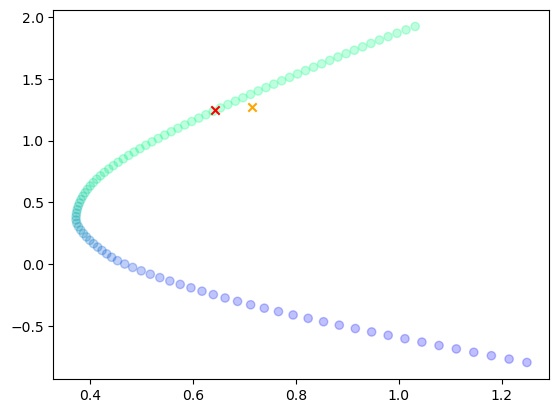

In [66]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [67]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2672.604561,0.593691,0.536978,0.056713
BTCUSDT,863.101425,0.191729,0.331386,-0.139657
SOLUSDT,350.228575,0.077800,0.000000,0.077800
JASMYUSDT,288.352007,0.064054,0.000000,0.064054
ETHUSDT,186.125111,0.041346,0.000000,0.041346
TRXUSDT,118.094985,0.026234,0.131636,-0.105402
BBUSDT,21.978623,0.004882,0.000000,0.004882
BNBUSDT,1.188460,0.000264,0.000000,0.000264
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [69]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [70]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

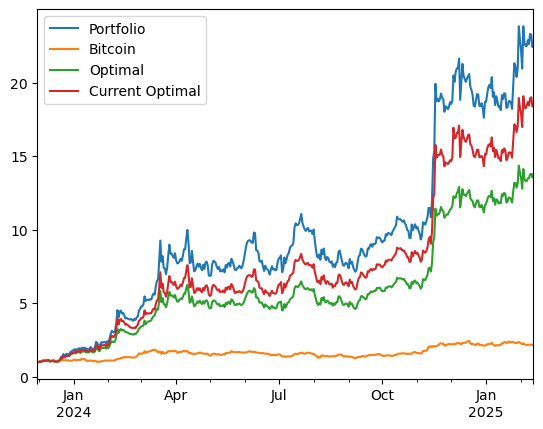

In [71]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [72]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

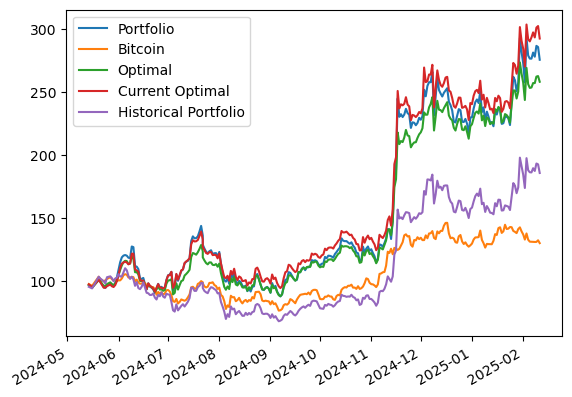

In [73]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [74]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-02-02,257.947710,133.129604,243.972978,270.457811,174.094032
2025-02-03,293.272545,137.983551,269.485585,303.910543,197.785838
2025-02-04,279.292171,133.040925,256.563330,292.159172,188.190244
2025-02-05,276.849807,131.465707,253.575108,290.527849,186.561035
2025-02-06,276.807278,131.386650,253.895804,293.680718,186.471769
2025-02-07,281.654227,131.321931,257.433127,297.665642,189.817980
2025-02-08,278.353098,131.237455,257.371456,293.657618,187.609350
2025-02-09,286.966785,131.261960,262.548017,301.479399,193.532660
2025-02-10,286.047158,132.572698,262.975920,302.699658,192.899874
2025-02-11,275.926436,130.304712,258.459932,292.786538,186.011212


## Volatilities

In [76]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.636911
 dtype: float64,
 0.6376153342663129)

In [77]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.715515
 dtype: float64,
 0.715515405165222)

In [78]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.823804
Bitcoin            0.424432
Optimal            0.637615
Current Optimal    0.740783
dtype: float64

In [79]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.46670743260821235

In [80]:
days=90
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.5464312859825413

In [81]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7757317488376967

## Risk Contribution

In [83]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.258852,0.169557,0.013647,0.058536,0.015857,0.042679
BTCUSDT,0.363005,0.300000,0.021119,0.117409,0.039879,0.077530
DEXEUSDT,0.001677,0.001010,0.000086,0.000545,0.000002,0.000542
OMUSDT,29.589318,0.425805,0.956107,0.773739,0.678900,0.094839
SUIUSDT,0.060649,0.035324,0.003057,0.019834,0.002778,0.017057
XRPUSDT,0.119550,0.068304,0.005984,0.029937,0.005211,0.024726


In [84]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,2.030439,0.536978,0.795773,0.829183,0.740159,0.089024
BTCUSDT,0.139654,0.331386,0.145999,0.106764,0.042282,0.064482
TRXUSDT,0.056223,0.131636,0.058227,0.064053,0.027864,0.036189


In [85]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,2.253462,0.595960,0.858102,0.831644,0.738716,0.092928
BTCUSDT,0.080880,0.191919,0.082153,0.056763,0.011491,0.045272
SOLUSDT,0.003747,0.080808,0.025464,0.042631,0.005603,0.037028
JASMYUSDT,-0.021373,0.060606,0.011815,0.045307,0.008762,0.036545
ETHUSDT,-0.009049,0.040404,0.009443,0.013732,0.000940,0.012791
TRXUSDT,0.012943,0.030303,0.013023,0.009924,0.001196,0.008728


# Value At Risk

## Historical

### Optimal Weights

In [89]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04841003371063072, -0.0738192279135175)

### Current Weights

In [91]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05013888766705832, -0.0755419253294489)

In [92]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [93]:
var=historical_var.iloc[row]
var

OMUSDT      -0.029483
BTCUSDT     -0.006012
SOLUSDT     -0.003001
JASMYUSDT   -0.008437
ETHUSDT     -0.001147
TRXUSDT     -0.001750
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049831
Name: 2025-01-19 00:00:00, dtype: float64

In [94]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.056454
BTCUSDT     -0.005134
SOLUSDT     -0.004254
JASMYUSDT   -0.005262
ETHUSDT     -0.001696
TRXUSDT     -0.001028
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.073828
dtype: float64

## Parametric

### Optimal Weights

In [97]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06606717537294494, -0.08467985226578666)

### Current Weights

In [99]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.07413887216104867, -0.09502553584757258)

## Multivariate

### Optimal Weights

In [102]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0589222821109685, -0.0755527759465091)

### Current Weights

In [104]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06812261579488448, -0.08613100248277797)

In [105]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.058006
BTCUSDT     -0.003326
SOLUSDT     -0.003249
JASMYUSDT   -0.002808
ETHUSDT     -0.000883
TRXUSDT     -0.000741
Portfolio   -0.069013
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [109]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058590709409786994, -0.07612138547361698)

### Current Weights

In [111]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06760183375328259, -0.08725160277528066)

In [112]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.055529
BTCUSDT     -0.004694
SOLUSDT     -0.003554
JASMYUSDT   -0.003462
ETHUSDT     -0.001190
TRXUSDT     -0.000631
Portfolio   -0.069060
dtype: float64

## Student Copula

### Optimal Weights

In [115]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05973960785543354, -0.0774409625913845)

### Current Weights

In [117]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07072888688593157, -0.09092643511860865)

In [118]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.058973
BTCUSDT     -0.003608
SOLUSDT     -0.003153
JASMYUSDT   -0.003265
ETHUSDT     -0.000900
TRXUSDT     -0.000556
Portfolio   -0.070454
dtype: float64

## Gumbel Copula

### Optimal Weights

In [121]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11991349299333488, -0.17020963983202334)

### Current Weights

In [123]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13935103667280627, -0.19484622532730209)

In [124]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.137465
BTCUSDT     -0.000545
SOLUSDT      0.000201
JASMYUSDT   -0.000117
ETHUSDT      0.000307
TRXUSDT     -0.000733
Portfolio   -0.138352
dtype: float64

## Monte Carlo

### Optimal

In [127]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [128]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06891410984248768, -0.0852940379577746)

### Current Weights

In [130]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07649587465853205, -0.09486435564937179)

In [131]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.062555
BTCUSDT     -0.004316
SOLUSDT     -0.003599
JASMYUSDT   -0.003435
ETHUSDT     -0.001060
TRXUSDT     -0.000759
Portfolio   -0.075724
dtype: float64

## VaR Violation

In [133]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054810,-0.097905,-0.083446,-0.019315
2024-01-15,-0.054810,-0.097916,-0.084411,0.023624
2024-01-16,-0.054810,-0.097790,-0.078255,0.047568
2024-01-17,-0.054810,-0.100093,-0.082614,-0.032219
2024-01-18,-0.054810,-0.101975,-0.086467,-0.028707
...,...,...,...,...
2025-02-08,-0.051804,-0.087305,-0.082194,-0.000240
2025-02-09,-0.051804,-0.086832,-0.084242,0.020113
2025-02-10,-0.051804,-0.086726,-0.081055,0.001630
2025-02-11,-0.051804,-0.086679,-0.080835,-0.017173


In [134]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.040879,-0.083190,-0.080831,-0.015422
2024-05-29,-0.040879,-0.080992,-0.077956,-0.007288
2024-05-30,-0.040879,-0.070732,-0.068583,0.027406
2024-05-31,-0.040879,-0.073632,-0.067302,0.043704
2024-06-01,-0.040879,-0.078741,-0.072554,0.059815
...,...,...,...,...
2025-02-08,-0.054467,-0.149036,-0.132835,-0.011721
2025-02-09,-0.054467,-0.142347,-0.128637,0.030945
2025-02-10,-0.054467,-0.136391,-0.128854,-0.003205
2025-02-11,-0.054467,-0.138453,-0.133616,-0.035381


<Axes: >

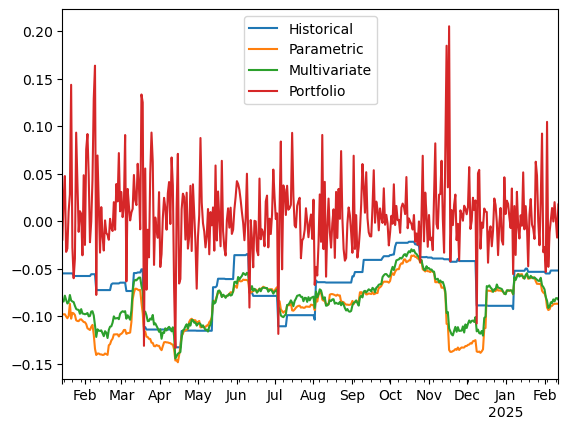

In [135]:
var_data.plot()

<Axes: >

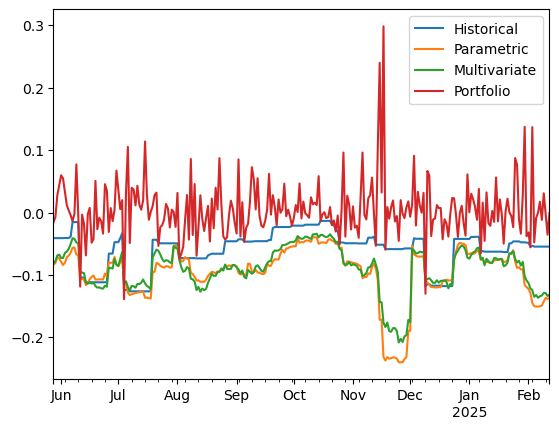

In [136]:
current_var_data.plot()

In [137]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020202,0.007576,0.010101
Kupiec Stat,9.466466,23.016896,19.459383
P-value,0.002093,0.000002,0.00001


In [138]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057471,0.015326,0.011494
Kupiec Stat,0.293238,8.966421,11.6809
P-value,0.588153,0.00275,0.000631


# Principal Component Analysis

## Historical PCA

In [141]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.7865129 , 0.06714658, 0.05736957, 0.04956114, 0.0394098 ])

In [142]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015880
ADAUSDT     0.015824
ALGOUSDT    0.018258
APTUSDT     0.016496
ARBUSDT     0.017643
              ...   
WBTCUSDT    0.009008
WLDUSDT     0.022201
XLMUSDT     0.013175
XRPUSDT     0.011384
XTZUSDT     0.016404
Name: PC1, Length: 62, dtype: float64

<Axes: >

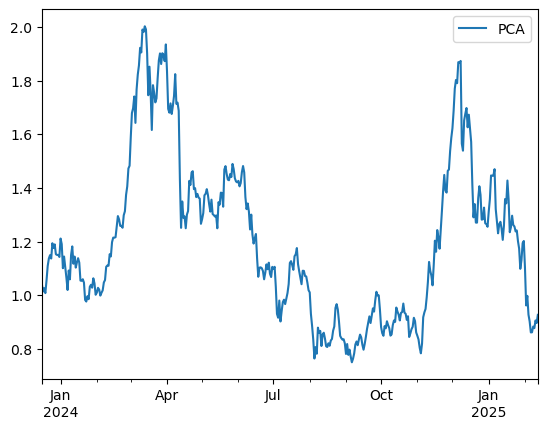

In [143]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

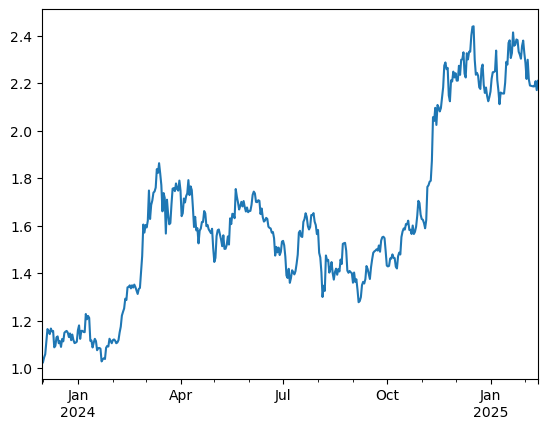

In [144]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [145]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.426156
WBETHUSDT    0.445632
ETHUSDT      0.445884
ATOMUSDT     0.466111
DOTUSDT      0.469136
ETCUSDT      0.470653
NEXOUSDT     0.481479
ADAUSDT      0.518425
EOSUSDT      0.527665
WBTCUSDT     0.528003
BTCUSDT      0.528586
AVAXUSDT     0.530590
IOTAUSDT     0.555665
FILUSDT      0.563655
ARBUSDT      0.572890
GRTUSDT      0.581606
XTZUSDT      0.586679
LINKUSDT     0.599167
SOLUSDT      0.608418
dtype: float64

<Axes: >

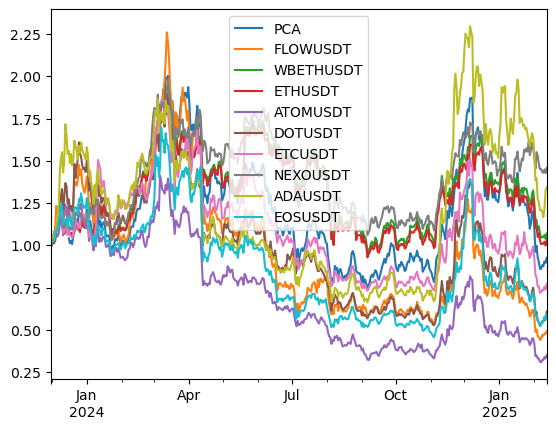

In [146]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

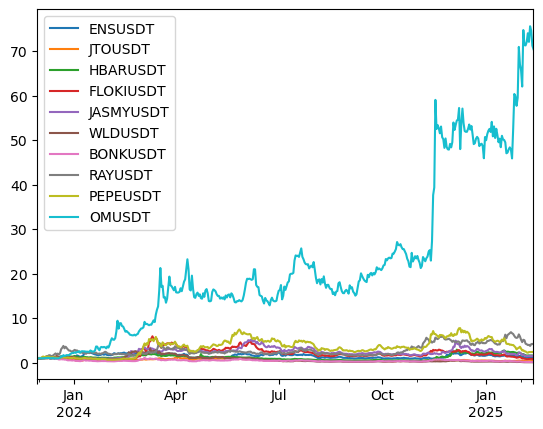

In [147]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [149]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.56869697, 0.14766287, 0.11832986, 0.09457925, 0.07073105])

In [150]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.094783
BTCUSDT      0.059108
SOLUSDT      0.097563
JASMYUSDT    0.175983
ETHUSDT      0.084498
TRXUSDT      0.055611
BBUSDT       0.207097
BNBUSDT      0.065763
PEPEUSDT     0.159595
Name: PC1, dtype: float64

<Axes: >

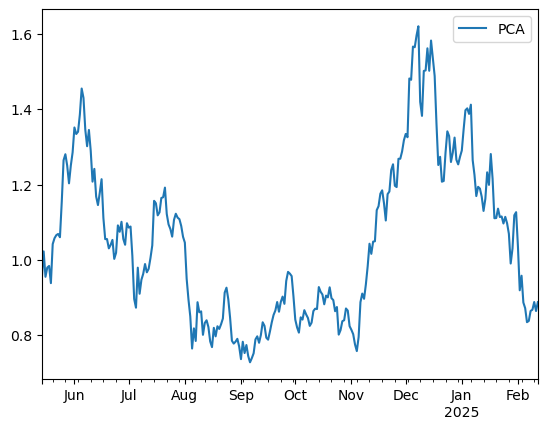

In [151]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

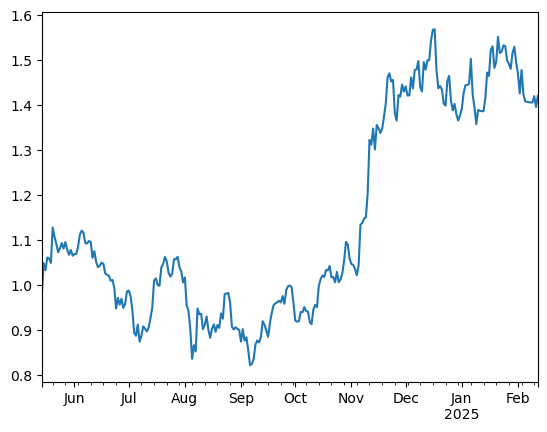

In [152]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.437216
BNBUSDT      0.477852
BTCUSDT      0.493149
SOLUSDT      0.495511
JASMYUSDT    0.693638
PEPEUSDT     0.747086
BBUSDT       0.780355
TRXUSDT      0.907130
OMUSDT       0.980464
dtype: float64

<Axes: >

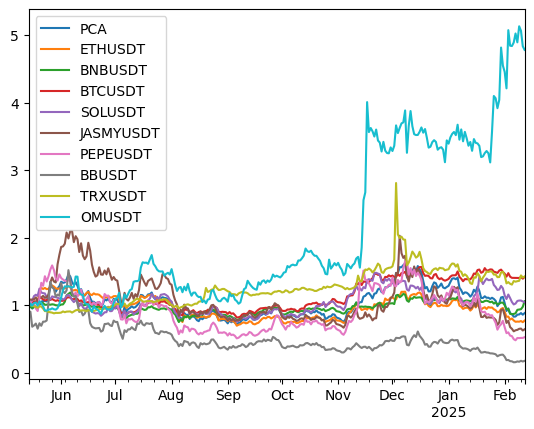

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [156]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.904922
BBUSDT       1.577499
JASMYUSDT    1.345462
SOLUSDT      1.163668
BTCUSDT      1.000000
ETHUSDT      0.973118
OMUSDT       0.894372
BNBUSDT      0.667504
TRXUSDT      0.330437
Name: BTCUSDT, dtype: float64

In [157]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.542191
PEPEUSDT     2.168331
BBUSDT       2.114751
SOLUSDT      1.372519
ETHUSDT      1.155905
OMUSDT       1.130520
TRXUSDT      1.034460
BTCUSDT      1.000000
BNBUSDT      0.788836
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [159]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [160]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.324710
BBUSDT,0.246987
TRXUSDT,0.159755
PEPEUSDT,0.141375
ETHUSDT,0.125519
SOLUSDT,0.095482
BNBUSDT,0.079831
JASMYUSDT,0.071193
OMUSDT,0.023708


### Regression to PCA

In [162]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.6489561541173071

In [163]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.307893
BNBUSDT      1.141100
ETHUSDT      1.026482
PCA          1.000000
SOLUSDT      0.757223
JASMYUSDT    0.440844
PEPEUSDT     0.419847
BBUSDT       0.386870
TRXUSDT      0.264045
OMUSDT       0.242466
dtype: float64

In [164]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.867565
ETHUSDT      1.237346
BNBUSDT      1.136287
TRXUSDT      1.133201
PCA          1.000000
BBUSDT       0.654859
PEPEUSDT     0.637070
JASMYUSDT    0.516236
SOLUSDT      0.452356
OMUSDT       0.273129
dtype: float64

### Correlation Matrix

<Axes: >

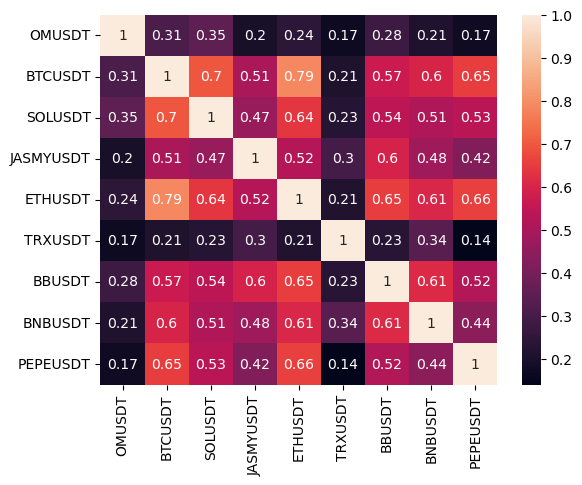

In [166]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

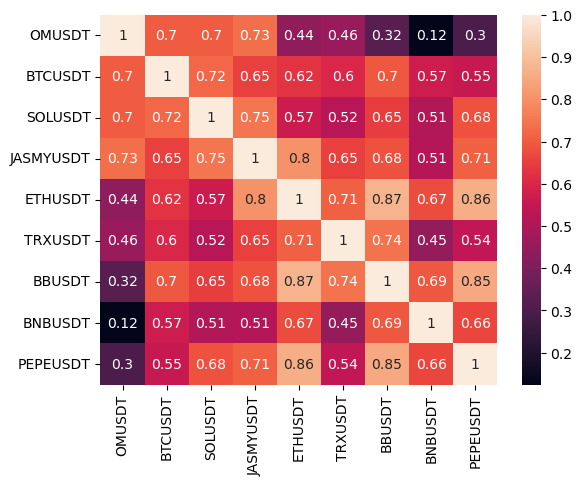

In [167]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [169]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [170]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-07-07,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-08-06,0.570170,0.058589,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.371242,0.0
2024-09-05,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.565809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003500,0.0
2024-10-05,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.600504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-04,0.000000,0.098784,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.009976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179542,0.0
2025-01-03,0.143622,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-02,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-12,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.32404,0.0,...,0.412491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [171]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

TRXUSDT      0.412491
BNBUSDT      0.324040
OMUSDT       0.147972
LTCUSDT      0.079554
FDUSDUSDT    0.035942
NEOUSDT      0.000000
Name: 2025-02-12 00:00:00, dtype: float64